### The model returns flat lines outside of the range of obervations

Pre-computing all data...
Generating data with SDE sampler...
  ...snapshot saved for t=0.0
  ...snapshot saved for t=0.2
  ...snapshot saved for t=0.5
  ...snapshot saved for t=0.8
  ...snapshot saved for t=1.0
  ...snapshot saved for t=1.2
Data pre-computation complete.

--- STEP 1: Finding Best Statistical h_x_factor (LogLikelihood Loss) ---
  Testing hx_factor=1.2264 -> LogLikelihood Loss: 2.183417e+05
  Testing hx_factor=1.7041 -> LogLikelihood Loss: 2.262757e+05
  Testing hx_factor=1.7301 -> LogLikelihood Loss: 2.268012e+05
  Testing hx_factor=1.7098 -> LogLikelihood Loss: 2.263897e+05
  Testing hx_factor=1.2848 -> LogLikelihood Loss: 2.191260e+05
  Testing hx_factor=0.8303 -> LogLikelihood Loss: 2.140753e+05
  Testing hx_factor=0.6653 -> LogLikelihood Loss: 2.126739e+05
  Testing hx_factor=0.2078 -> LogLikelihood Loss: 2.101095e+05
  Testing hx_factor=0.6180 -> LogLikelihood Loss: 2.123091e+05
  Testing hx_factor=1.0076 -> LogLikelihood Loss: 2.157950e+05
  Testing hx_factor=0.1

C:\Users\Kai\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1] before, using random point [1.6905288619123706]
  warnings.warn(


  Testing hx_factor=1.6905 -> LogLikelihood Loss: 2.260046e+05


C:\Users\Kai\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1] before, using random point [1.6150212984659826]
  warnings.warn(


  Testing hx_factor=1.6150 -> LogLikelihood Loss: 2.245408e+05


C:\Users\Kai\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1] before, using random point [0.7399198871046705]
  warnings.warn(


  Testing hx_factor=0.7399 -> LogLikelihood Loss: 2.132842e+05
  Testing hx_factor=0.1001 -> LogLikelihood Loss: 2.098767e+05


C:\Users\Kai\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1] before, using random point [0.7423332063190555]
  warnings.warn(


  Testing hx_factor=0.7423 -> LogLikelihood Loss: 2.133046e+05
  Testing hx_factor=0.1000 -> LogLikelihood Loss: 2.098766e+05


C:\Users\Kai\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1] before, using random point [0.6324651596196429]
  warnings.warn(


  Testing hx_factor=0.6325 -> LogLikelihood Loss: 2.124185e+05


C:\Users\Kai\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1] before, using random point [1.647812857945178]
  warnings.warn(


  Testing hx_factor=1.6478 -> LogLikelihood Loss: 2.251671e+05
  Testing hx_factor=0.1001 -> LogLikelihood Loss: 2.098767e+05
  Testing hx_factor=0.1003 -> LogLikelihood Loss: 2.098770e+05
  Testing hx_factor=0.1002 -> LogLikelihood Loss: 2.098769e+05
  Testing hx_factor=0.1001 -> LogLikelihood Loss: 2.098767e+05
  Testing hx_factor=0.1005 -> LogLikelihood Loss: 2.098773e+05
--- Best Statistical h_x_factor found: 0.1000 ---

--- STEP 2: Finding Best Physical h_v_global (with h_x_factor fixed) ---
  Testing hv=0.3005 (with hx_factor=0.1000) -> Physics Loss: 4.276539e-01
  Testing hv=0.4237 (with hx_factor=0.1000) -> Physics Loss: 5.990402e-01
  Testing hv=0.4304 (with hx_factor=0.1000) -> Physics Loss: 6.116572e-01
  Testing hv=0.4252 (with hx_factor=0.1000) -> Physics Loss: 6.017612e-01
  Testing hv=0.3155 (with hx_factor=0.1000) -> Physics Loss: 4.432049e-01
  Testing hv=0.1983 (with hx_factor=0.1000) -> Physics Loss: 3.518496e-01
  Testing hv=0.1558 (with hx_factor=0.1000) -> Physics

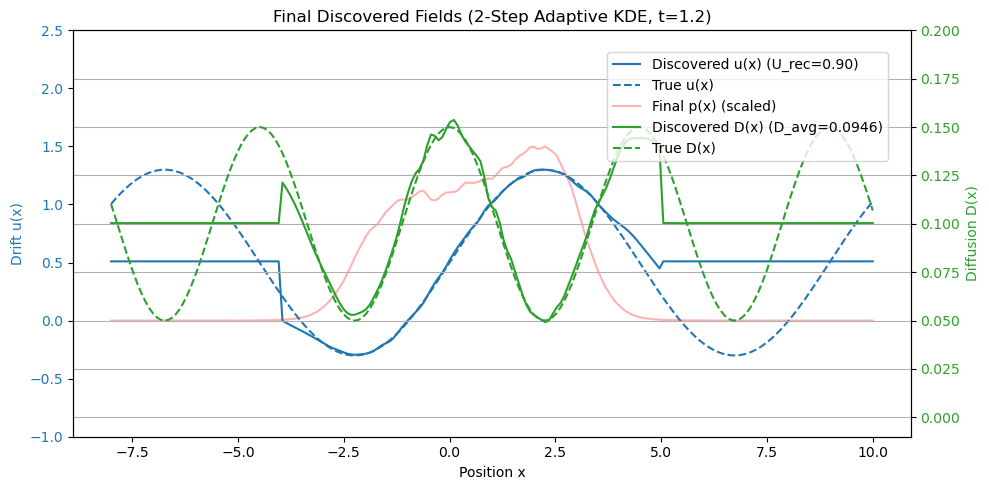

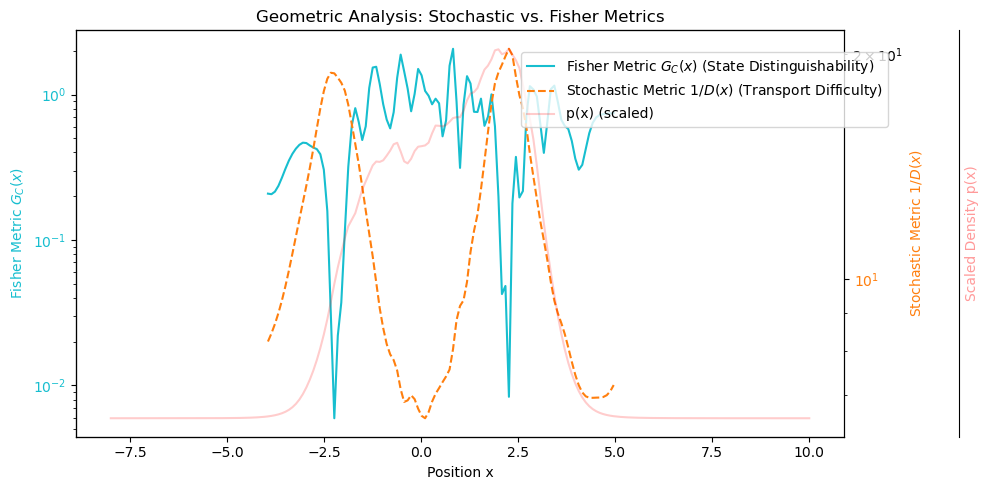

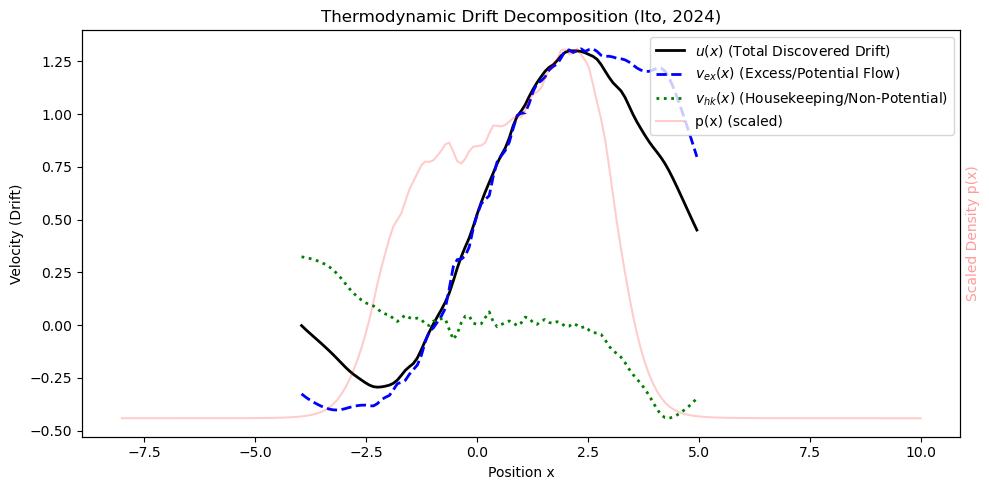

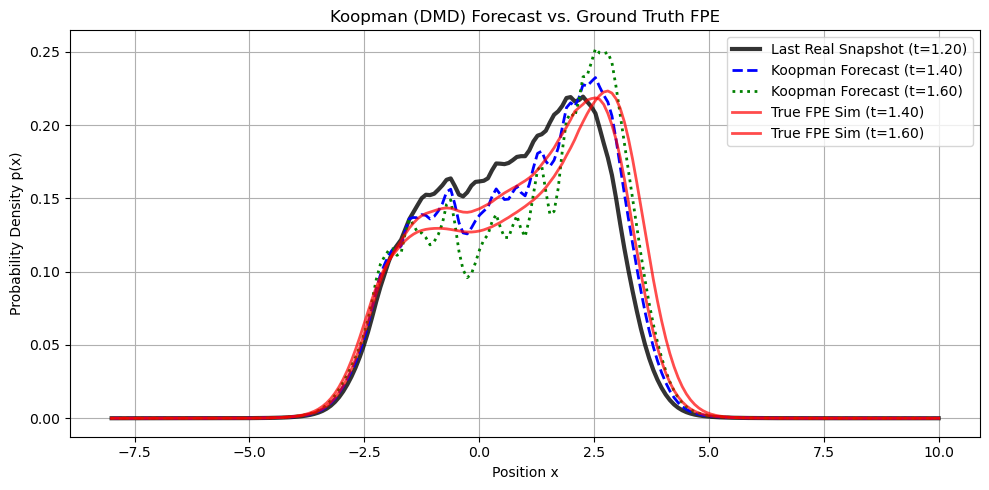

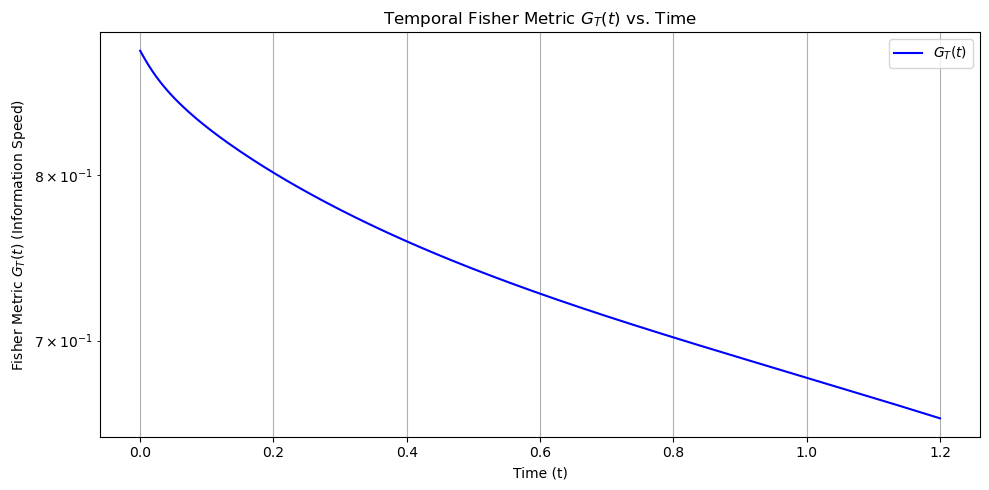

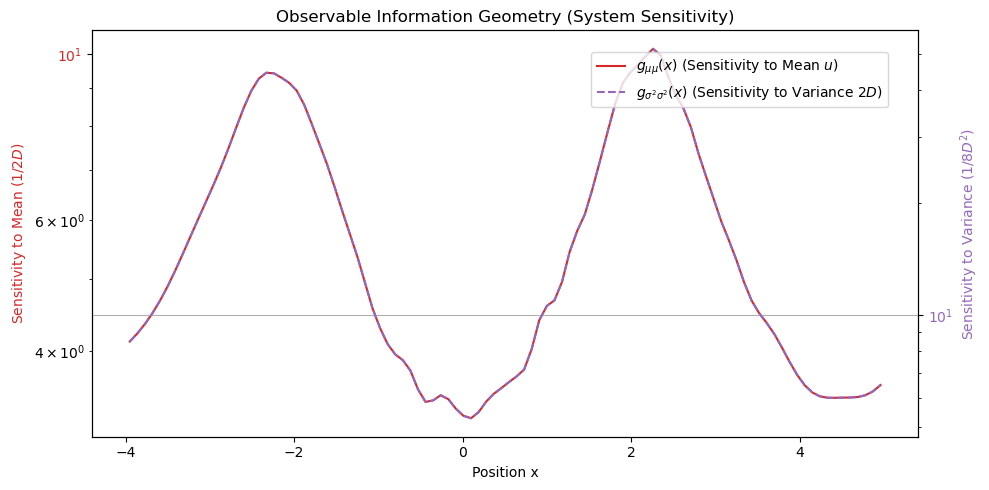

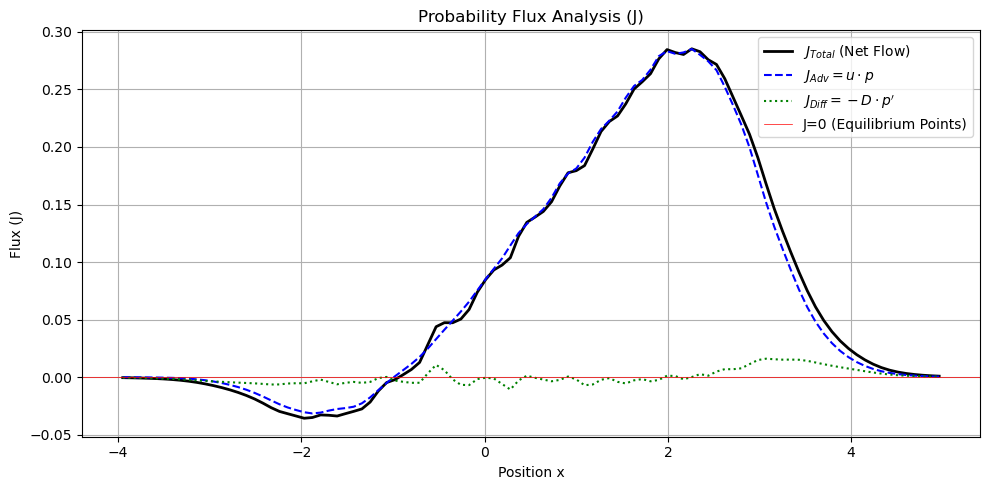

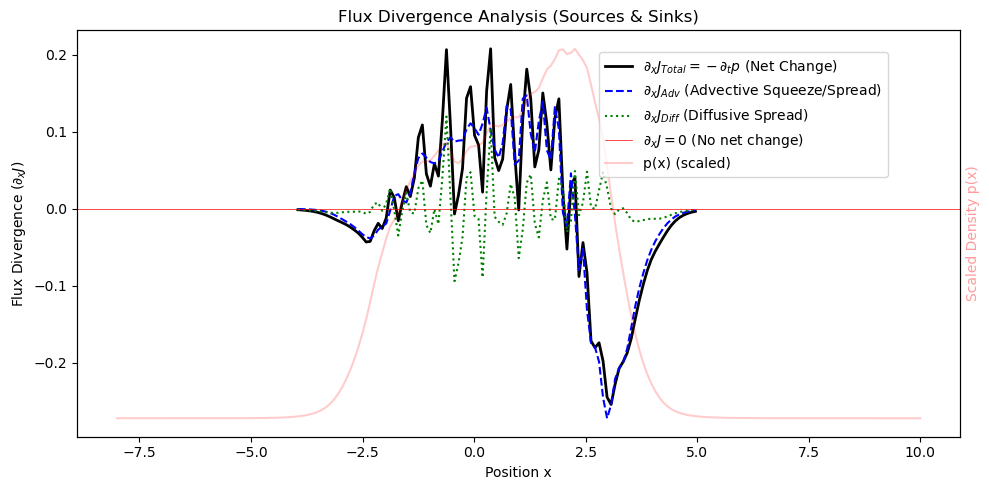

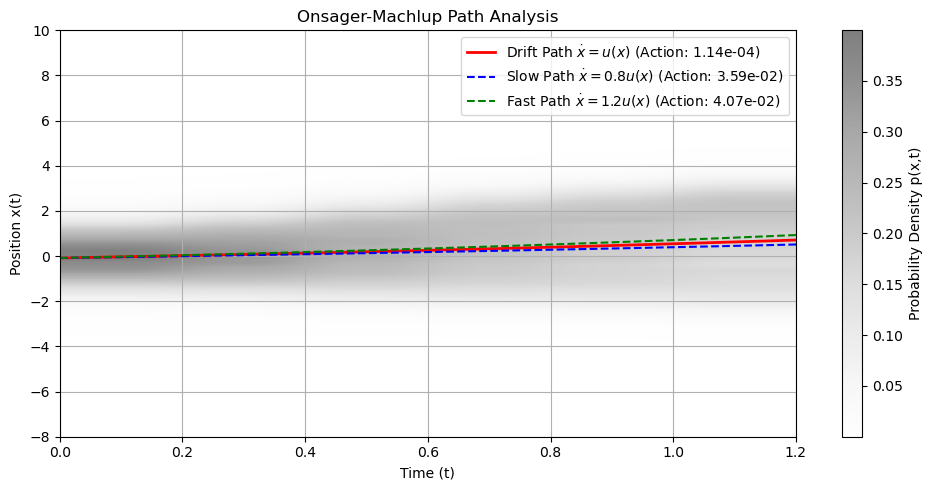

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from sklearn.model_selection import train_test_split
# --- *** NEW *** FPE SOLVER ---

def fpe_rhs(p, u, D, dx):
    """
    Calculates the right-hand-side of the Fokker-Planck Equation:
    dp/dt = - dJ/dx
    J = u*p - D*(dp/dx)
    """
    # Calculate dp/dx using central differences
    grad_p = np.gradient(p, dx)
    
    # Calculate the flux J
    J = u * p - D * grad_p
    
    # Calculate dJ/dx
    dJ_dx = np.gradient(J, dx)
    
    return -dJ_dx

def solve_fpe_forward(u_field, D_field, p_initial, grid_x, target_times, dt_pde=1e-5):
    """
    Solves the FPE forward in time from p_initial using Forward Euler.
    """
    dx = grid_x[1] - grid_x[0]
    
    # Check for stability (this dt_pde is likely small enough, but a real
    # implementation would calculate the CFL condition)
    # dt_cfl_diff = 0.5 * dx**2 / np.max(D_field)
    # dt_cfl_adv = dx / np.max(u_field)
    # print(f"  FPE Solver: Diffusive CFL = {dt_cfl_diff:.6f}, Advective CFL = {dt_cfl_adv:.6f}")
    
    p_current = p_initial.copy()
    current_time = 0.0
    
    forecast_snapshots = []
    
    for t_target in target_times:
        # Simulate from current_time up to t_target
        n_steps = int(np.ceil((t_target - current_time) / dt_pde))
        if n_steps <= 0:
            continue
            
        for _ in range(n_steps):
            # Calculate the time derivative
            dp_dt = fpe_rhs(p_current, u_field, D_field, dx)
            
            # Step forward with Forward Euler
            p_current = p_current + dt_pde * dp_dt
            
            # Enforce conservation (optional but good)
            p_current[p_current < 0] = 0
            p_current = p_current / (np.sum(p_current) * dx + 1e-30)

        current_time = t_target
        forecast_snapshots.append(p_current.copy())
        
    return forecast_snapshots
    
# --- 1. Helper Functions (KDEs, Physics, etc.) ---

def kde_1d(samples_x, grid_x, h_x):
    """(UNCHANGED) Builds a 1D Gaussian KDE. (Used for pilot density)"""
    p_x = np.zeros_like(grid_x)
    n = len(samples_x)
    if n == 0:
        return p_x
    for xi in samples_x:
        z = (grid_x - xi) / h_x
        K = np.exp(-0.5 * z**2) / (sqrt(2 * pi) * h_x)
        p_x += K
    p_x /= n
    return p_x

def get_adaptive_hx(samples_x, h_x_global_factor, grid_x, alpha=0.5):
    """(UNCHANGED) Computes per-sample adaptive bandwidths h_i."""
    N = len(samples_x)
    if N == 0: 
        return np.array([])
    h_pilot = np.std(samples_x) * (4.0/(3.0*N))**(1.0/5.0)
    if h_pilot < 1e-6: h_pilot = 1e-6
    p_pilot_grid = kde_1d(samples_x, grid_x, h_pilot)
    p_at_samples = np.interp(samples_x, grid_x, p_pilot_grid)
    p_at_samples[p_at_samples < 1e-10] = 1e-10
    g = np.exp(np.mean(np.log(p_at_samples)))
    h_i_array = h_x_global_factor * (p_at_samples / g)**(-alpha)
    h_i_array = np.clip(h_i_array, a_min=h_pilot * 0.05, a_max=h_pilot * 20.0)
    return h_i_array

def kde_1d_adaptive(samples_x, grid_x, h_x_global_factor, pilot_grid_x):
    """(UNCHANGED) Builds a 1D Gaussian KDE on a grid with ADAPTIVE h_x."""
    p_x = np.zeros_like(grid_x)
    n = len(samples_x)
    if n == 0:
        return p_x
    
    h_i_array = get_adaptive_hx(samples_x, h_x_global_factor, pilot_grid_x)
    
    for i in range(n):
        xi = samples_x[i]
        h_x_i = h_i_array[i] # Get adaptive bandwidth
        
        z = (grid_x - xi) / h_x_i
        K = np.exp(-0.5 * z**2) / (sqrt(2 * pi) * h_x_i)
        p_x += K
        
    p_x /= n
    return p_x

def kde_2d_analytic(samples_xv, grid_x, grid_v, h_x_global_factor, h_v_global):
    """(UNCHANGED) Builds a 2D Gaussian KDE with ADAPTIVE h_x and its analytic derivatives."""
    N = samples_xv.shape[0];
    if N == 0: return np.zeros((3, len(grid_v), len(grid_x)))
    X, V = np.meshgrid(grid_x, grid_v)
    p_xv, dp_dx, d2p_dx2 = np.zeros_like(X), np.zeros_like(X), np.zeros_like(X)
    h_i_array = get_adaptive_hx(samples_xv[:, 0], h_x_global_factor, grid_x)
    h_v = h_v_global
    for i in range(N):
        xi, vi = samples_xv[i, 0], samples_xv[i, 1]
        h_x_i = h_i_array[i]
        zx = (X - xi) / h_x_i; zv = (V - vi) / h_v
        K_norm = (1.0 / (2 * pi * h_x_i * h_v)); K_base = np.exp(-0.5 * (zx**2 + zv**2)); K = K_norm * K_base
        p_xv += K; dp_dx += -(zx / h_x_i) * K; d2p_dx2 += ((zx**2 - 1) / h_x_i**2) * K
    p_xv /= N; dp_dx /= N; d2p_dx2 /= N
    return p_xv, dp_dx, d2p_dx2 

def calculate_physics_analytic(p_xv, dp_dx, d2p_dx2, grid_v, p_thresh=1e-3):
    """(UNCHANGED) Calculates u, D, p and their ANALYTIC gradients."""
    dv = grid_v[1] - grid_v[0]; v_col = grid_v[:, np.newaxis]
    p_x = np.sum(p_xv, axis=0) * dv; dp_dx_analytic = np.sum(dp_dx, axis=0) * dv; d2p_dx2_analytic = np.sum(d2p_dx2, axis=0) * dv
    I_p = p_x; I_v = np.sum(v_col * p_xv, axis=0) * dv; I_v2 = np.sum((v_col**2) * p_xv, axis=0) * dv
    dI_p_dx = dp_dx_analytic; dI_v_dx = np.sum(v_col * dp_dx, axis=0) * dv; dI_v2_dx = np.sum((v_col**2) * dp_dx, axis=0) * dv
    mask = I_p > p_thresh; u_rec, D_rec = np.zeros_like(p_x), np.zeros_like(p_x)
    u_rec[mask] = I_v[mask] / (I_p[mask] + 1e-30)
    E_v_squared = np.zeros_like(p_x); E_v_squared[mask] = I_v2[mask] / (I_p[mask] + 1e-30)
    Var_v = E_v_squared - (u_rec**2); D_rec = 0.5 * Var_v
    du_dx, dD_dx = np.zeros_like(p_x), np.zeros_like(p_x)
    du_dx[mask] = (dI_v_dx[mask] * I_p[mask] - I_v[mask] * dI_p_dx[mask]) / (I_p[mask]**2 + 1e-30)
    dE_v_squared_dx = np.zeros_like(p_x); dE_v_squared_dx[mask] = (dI_v2_dx[mask] * I_p[mask] - I_v2[mask] * dI_p_dx[mask]) / (I_p[mask]**2 + 1e-30)
    dD_dx = 0.5 * (dE_v_squared_dx - 2 * u_rec * du_dx)
    if np.any(mask):
        u_rec[~mask] = np.median(u_rec[mask]); D_rec[~mask] = np.median(D_rec[mask])
        du_dx[~mask] = 0.0; dD_dx[~mask] = 0.0; D_rec[D_rec < 1e-6] = 1e-6
    else:
        D_rec[D_rec < 1e-6] = 1e-6
    
    # Clean D_final from noise in tails (where p is small)
    D_rec[~mask] = D_rec[mask].mean() # Use mean instead of median for stability
    u_rec[~mask] = u_rec[mask].mean()
    D_rec[D_rec < 1e-6] = 1e-6 # Final clamp
        
    return u_rec, D_rec, p_x, dp_dx_analytic, d2p_dx2_analytic, du_dx, dD_dx
    
def kde_2d(samples_xv, grid_x, grid_v, h_x_global_factor, h_v_global):
    """(UNCHANGED) Builds a 2D Gaussian KDE on a grid with ADAPTIVE h_x."""
    N = samples_xv.shape[0];
    if N == 0: return np.zeros((len(grid_v), len(grid_x)))
    X, V = np.meshgrid(grid_x, grid_v); p_xv = np.zeros_like(X)
    h_i_array = get_adaptive_hx(samples_xv[:, 0], h_x_global_factor, grid_x)
    h_v = h_v_global
    for i in range(N):
        xi, vi = samples_xv[i, 0], samples_xv[i, 1]; h_x_i = h_i_array[i]
        zx = (X - xi) / h_x_i; zv = (V - vi) / h_v
        K = (1.0 / (2 * pi * h_x_i * h_v)) * np.exp(-0.5 * (zx**2 + zv**2))
        p_xv += K
    p_xv /= N
    return p_xv

def calculate_physics_from_2d_kde(p_xv, grid_v, p_thresh=1e-3):
    """(UNCHANGED) Calculates u(x), D(x), and p(x) from a 2D KDE."""
    dv = grid_v[1] - grid_v[0]; p_x = np.sum(p_xv, axis=0) * dv
    v_col = grid_v[:, np.newaxis]; mask = p_x > p_thresh
    u_rec, D_rec = np.zeros_like(p_x), np.zeros_like(p_x)
    numerator_u = np.sum(v_col * p_xv, axis=0) * dv
    u_rec[mask] = numerator_u[mask] / p_x[mask]
    numerator_D = np.sum((v_col**2) * p_xv, axis=0) * dv
    E_v_squared = np.zeros_like(p_x); E_v_squared[mask] = numerator_D[mask] / p_x[mask]
    Var_v = E_v_squared - (u_rec**2); D_rec = 0.5 * Var_v
    if np.any(mask):
        # Fill tails with mean value from trusted region
        u_rec[~mask] = np.mean(u_rec[mask])
        D_rec[~mask] = np.mean(D_rec[mask])
        D_rec[D_rec < 1e-6] = 1e-6
    else:
        D_rec[D_rec < 1e-6] = 1e-6
    return u_rec, D_rec, p_x

def compute_Re_from_u_p_D(u, p_x, D, grid, mask_thresh=None):
    """(UNCHANGED) Calculates final Re, U, L, and D_avg from the discovered fields."""
    dx = grid[1] - grid[0]
    if mask_thresh is not None:
        mask = p_x > mask_thresh
        if not np.any(mask): return 0.0, 0.0, 0.0, 0.0
        p_masked, u_masked, D_masked, grid_masked = p_x[mask], u[mask], D[mask], grid[mask]
        p_sum = np.sum(p_masked) * dx; U = np.sqrt(np.sum(p_masked * (u_masked**2)) * dx / p_sum)
        mean = np.sum(p_masked * grid_masked) * dx / (p_sum + 1e-30)
        L = np.sqrt(np.sum(p_masked * (grid_masked - mean)**2) * dx / (p_sum + 1e-30))
        D_avg = np.sum(p_masked * D_masked) * dx / p_sum
    else:
        p_sum = np.sum(p_x) * dx; U = np.sqrt(np.sum(p_x * (u**2)) * dx / p_sum)
        mean = np.sum(p_x * grid) * dx / (p_sum + 1e-30)
        L = np.sqrt(np.sum(p_x * (grid - mean)**2) * dx / (p_sum + 1e-30))
        D_avg = np.sum(p_x * D) * dx / p_sum
    Re = (U * L) / (D_avg + 1e-30)
    return Re, U, L, D_avg

def sample_sde_2d(u_func, D_func, mu0, sigma0_x, n_samples, all_times, dt=0.001):
    """(UNCHANGED, with typo fixed) Generates synthetic 2D data (x, v)."""
    print("Generating data with SDE sampler...")
    data = {}; X = np.random.normal(mu0, sigma0_x, n_samples)
    time_targets = sorted(list(all_times)); current_time = 0.0
    for t_target in time_targets:
        if t_target > current_time:
            n_steps_needed = int(np.ceil((t_target - current_time) / dt))
            dt_actual = (t_target - current_time) / n_steps_needed
            for _ in range(n_steps_needed):
                u_at_x = u_func(X); D_at_x = D_func(X)
                D_at_x[D_at_x < 0] = 1e-6 
                dW = np.random.normal(0.0, 1.0, n_samples) * np.sqrt(dt_actual) # Fixed typo
                X = X + u_at_x * dt_actual + np.sqrt(2 * D_at_x) * dW
            current_time = t_target
        u_at_x = u_func(X); D_at_x = D_func(X)
        D_at_x[D_at_x < 0] = 1e-6
        sigma_v_at_x = np.sqrt(2 * D_at_x)
        v_samples = np.random.normal(loc=u_at_x, scale=sigma_v_at_x, size=n_samples)
        data[t_target] = np.stack([X, v_samples], axis=1)
        print(f"  ...snapshot saved for t={t_target}")
    return data

# --- 2. The Two-Step Optimization ---

# Global data store
GLOBAL_DATA = {}

def create_global_data(u_true_func, D_true_func, mu0, sigma0_x, n_samples):
    """Pre-computes all data."""
    print("Pre-computing all data...")
    all_times = [0.0, 0.2, 0.5, 0.8, 1.0, 1.2]
    
    samples_by_t = sample_sde_2d(
        u_true_func, D_true_func, mu0, sigma0_x, n_samples, all_times
    )
    
    grid_x = np.linspace(-8, 10, 201)
    grid_v = np.linspace(-2, 4, 51)
    
    all_samples_x = np.concatenate([s[:, 0] for s in samples_by_t.values()])
    x_train, x_test = train_test_split(all_samples_x, test_size=0.5, random_state=0)
    
    GLOBAL_DATA['samples_by_t'] = samples_by_t
    GLOBAL_DATA['grid_x'] = grid_x
    GLOBAL_DATA['grid_v'] = grid_v
    GLOBAL_DATA['all_times'] = all_times
    GLOBAL_DATA['p_thresh'] = 1e-3
    GLOBAL_DATA['x_train'] = x_train
    GLOBAL_DATA['x_test'] = x_test
    GLOBAL_DATA['u_true_func'] = u_true_func
    GLOBAL_DATA['D_true_func'] = D_true_func
    
    print("Data pre-computation complete.")

# --- STEP 1: Find Best h_x_global_factor (Statistical) ---

space_hx = [Real(0.1, 2.0, name='h_x_global_factor')]

@use_named_args(space_hx)
def objective_find_h_x(h_x_global_factor):
    """(UNCHANGED) Finds the best h_x_global_factor using statistical cross-validation."""
    x_train = GLOBAL_DATA['x_train']
    x_test = GLOBAL_DATA['x_test']
    grid_x = GLOBAL_DATA['grid_x']
    
    p_x_train = kde_1d_adaptive(x_train, grid_x, h_x_global_factor, grid_x)
    log_p_interp = np.log(np.interp(x_test, grid_x, p_x_train) + 1e-30)
    loss = -np.sum(log_p_interp)
    
    print(f"  Testing hx_factor={h_x_global_factor:.4f} -> LogLikelihood Loss: {loss:.6e}")
    return loss

# --- STEP 2: Find Best h_v (Physical) ---

space_hv = [Real(0.01, 0.5, name='h_v_global')]

@use_named_args(space_hv)
def objective_find_h_v(h_v_global):
    """(UNCHANGED) Finds the best h_v_global by minimizing the PHYSICS RESIDUAL."""
    samples_by_t = GLOBAL_DATA['samples_by_t']
    grid_x = GLOBAL_DATA['grid_x']
    grid_v = GLOBAL_DATA['grid_v']
    all_times = GLOBAL_DATA['all_times']
    p_thresh = GLOBAL_DATA['p_thresh']
    
    h_x_factor = GLOBAL_DATA['h_x_factor_best'] 
    
    dv = grid_v[1] - grid_v[0]
    dx = grid_x[1] - grid_x[0]

    p_x_t, J_t = [], []
    for t in all_times:
        p_xv_t = kde_2d(samples_by_t[t], grid_x, grid_v, h_x_factor, h_v_global)
        u_t, D_t, p_t = calculate_physics_from_2d_kde(p_xv_t, grid_v, p_thresh)
        grad_p_t = np.gradient(p_t, dx)
        J = u_t * p_t - D_t * grad_p_t
        p_x_t.append(p_t)
        J_t.append(J)
        
    dp_dt = np.zeros(np.array(p_x_t).shape)
    for i in range(1, len(all_times) - 1):
        dt = all_times[i+1] - all_times[i-1]
        dp_dt[i] = (p_x_t[i+1] - p_x_t[i-1]) / (dt + 1e-30)
        
    div_J = np.zeros(np.array(J_t).shape)
    for i in range(len(all_times)):
        div_J[i] = np.gradient(J_t[i], dx)
        
    residual = dp_dt[1:-1] + div_J[1:-1]
    p_avg = np.mean(p_x_t, axis=0)
    mask = p_avg > p_thresh

    if not np.any(mask):
        loss = 1e10
    else:
        loss = np.sum((residual[:, mask])**2)
    
    print(f"  Testing hv={h_v_global:.4f} (with hx_factor={h_x_factor:.4f}) -> Physics Loss: {loss:.6e}")
    return loss

# Post-Processing: Geometric & DMD Analysis ---

def calculate_geometric_metrics(u, D, u_prime, D_prime, p, grid_x, p_thresh):
    """
    Calculates the Stochastic Metric (1/D) and the Fisher Metric G_C(x)
    using the *analytic* derivatives u_prime and D_prime.
    """
    print("\n--- Running Geometric Analysis ---")
    
    # 1. Derivatives are now passed in as arguments
    # u_prime = np.gradient(u, dx) # --- DELETED ---
    # D_prime = np.gradient(D, dx) # --- DELETED ---
    
    # 2. Calculate Stochastic Metric (g_xx = 1/D)
    metric_stochastic = 1.0 / (D + 1e-30) 
    
    # 3. Calculate Fisher Metric (G_C(x))
    # G_C(x) = (u')^2 / (2D) + (D')^2 / (2D^2)
    term1 = (u_prime**2) / (2 * D + 1e-30)
    term2 = (D_prime**2) / (2 * D**2 + 1e-30)
    metric_fisher = term1 + term2
    
    # 4. Create mask based on probability density
    mask = p > p_thresh
    
    # --- Plotting (no changes here) ---
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_title("Geometric Analysis: Stochastic vs. Fisher Metrics")
    ax1.set_xlabel("Position x")
    
    color1 = 'tab:cyan'
    ax1.plot(grid_x[mask], metric_fisher[mask], color=color1, label="Fisher Metric $G_C(x)$ (State Distinguishability)")
    ax1.set_ylabel("Fisher Metric $G_C(x)$", color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_yscale('log') 
    
    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.plot(grid_x[mask], metric_stochastic[mask], color=color2, ls='--', label="Stochastic Metric $1/D(x)$ (Transport Difficulty)")
    ax2.set_ylabel("Stochastic Metric $1/D(x)$", color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.set_yscale('log')
    
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('axes', 1.15))
    ax3.plot(grid_x, p / np.max(p), 'r-', alpha=0.2, label="p(x) (scaled)")
    ax3.set_ylabel("Scaled Density p(x)", color='r', alpha=0.4)
    # This is the line from the ValueError fix
    ax3.tick_params(axis='y', labelcolor='r') 
    ax3.set_yticks([]) 
    
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.grid(True)
    fig.tight_layout()
    
    return metric_stochastic, metric_fisher

def run_dmd_forecast(h_x_factor, h_v_global):
    """
    Runs SVD/DMD analysis AND compares forecast to a true FPE simulation.
    """
    print("\n--- Running DMD/Koopman Forecast Analysis ---")
    
    # --- 1. Re-generate all p(x,t) snapshots (for DMD) ---
    samples_by_t = GLOBAL_DATA['samples_by_t']
    grid_x = GLOBAL_DATA['grid_x']
    grid_v = GLOBAL_DATA['grid_v']
    all_times = GLOBAL_DATA['all_times']
    p_thresh = GLOBAL_DATA['p_thresh']
    
    p_x_t_snapshots = []
    print("  Re-generating p(x,t) snapshots...")
    for t in all_times:
        p_xv_t = kde_2d(samples_by_t[t], grid_x, grid_v, h_x_factor, h_v_global)
        _, _, p_t = calculate_physics_from_2d_kde(p_xv_t, grid_v, p_thresh)
        p_x_t_snapshots.append(p_t)
        
    # --- 2. Build DMD Data Matrices ---
    X = np.stack(p_x_t_snapshots, axis=1) 
    X1 = X[:, :-1]; X2 = X[:, 1:]
    print(f"  DMD data matrix shape: {X.shape}")
    
    # --- 3. Compute Koopman Operator ---
    A = X2 @ np.linalg.pinv(X1)
    print(f"  Koopman operator 'A' shape: {A.shape}")

    # --- 4. Get Koopman Forecast ---
    dt_snapshot = all_times[1] - all_times[0] # Snapshot time step
    last_snapshot = X[:, -1]
    
    p_koop_forecast_1 = A @ last_snapshot
    p_koop_forecast_2 = A @ p_koop_forecast_1
    p_koop_forecast_1[p_koop_forecast_1 < 0] = 0
    p_koop_forecast_2[p_koop_forecast_2 < 0] = 0
    
    forecast_times = [dt_snapshot, 2 * dt_snapshot]
    t_forecast_1 = all_times[-1] + dt_snapshot
    t_forecast_2 = all_times[-1] + 2 * dt_snapshot

    # --- 5. *** NEW *** Get "Ground Truth" FPE Forecast ---
    print("  Running 'Ground Truth' FPE simulation...")
    u_true_on_grid = GLOBAL_DATA['u_true_func'](grid_x)
    D_true_on_grid = GLOBAL_DATA['D_true_func'](grid_x)
    
    # Solve the FPE starting from the *same last snapshot*
    p_fpe_forecasts = solve_fpe_forward(
        u_true_on_grid, 
        D_true_on_grid, 
        last_snapshot, 
        grid_x, 
        forecast_times
    )
    p_fpe_forecast_1 = p_fpe_forecasts[0]
    p_fpe_forecast_2 = p_fpe_forecasts[1]

    # --- 6. Plotting ---
    plt.figure(figsize=(10, 5))
    plt.title("Koopman (DMD) Forecast vs. Ground Truth FPE")
    plt.xlabel("Position x")
    plt.ylabel("Probability Density p(x)")
    
    # Plot last real snapshot
    plt.plot(grid_x, last_snapshot, 'k-', lw=3, alpha=0.8, label=f"Last Real Snapshot (t={all_times[-1]:.2f})")
    
    # Plot Koopman forecast
    plt.plot(grid_x, p_koop_forecast_1, 'b--', lw=2, label=f"Koopman Forecast (t={t_forecast_1:.2f})")
    plt.plot(grid_x, p_koop_forecast_2, 'g:', lw=2, label=f"Koopman Forecast (t={t_forecast_2:.2f})")
    
    # Plot "Ground Truth" FPE forecast
    plt.plot(grid_x, p_fpe_forecast_1, 'r-', lw=2, alpha=0.7, label=f"True FPE Sim (t={t_forecast_1:.2f})")
    plt.plot(grid_x, p_fpe_forecast_2, 'r-', lw=2, alpha=0.7, label=f"True FPE Sim (t={t_forecast_2:.2f})")
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

def calculate_temporal_fisher_metric(u_field, D_field, p_initial, grid_x, end_time, dt_pde=1e-4):
    """
    Solves the FPE and calculates G_T(t) using a
    numerically stable formulation and correct array sizing.
    """
    print("\n--- Running Temporal Fisher Metric (G_T) Analysis ---")
    dx = grid_x[1] - grid_x[0]
    
    p_current = p_initial.copy()
    current_time = 0.0
    
    # --- THIS BLOCK IS THE FIX ---
    # Initialize both lists with their t=0 values.
    time_values = [0.0]
    
    dp_dt_t0 = fpe_rhs(p_current, u_field, D_field, dx)
    d_log_p_dt_t0 = dp_dt_t0 / (p_current + 1e-30)
    integrand_t0 = (d_log_p_dt_t0**2) * p_current
    g_t_t0 = np.sum(integrand_t0) * dx
    
    g_t_values = [g_t_t0]
    # --- END FIX ---
    
    n_steps = int(np.ceil(end_time / dt_pde))
    report_every = int(n_steps / 200) # Save 200 data points
    if report_every == 0: report_every = 1

    print(f"  Simulating FPE for {n_steps} steps...")
    
    for i in range(n_steps):
        # 1. Calculate the time derivative of p at time t
        dp_dt = fpe_rhs(p_current, u_field, D_field, dx)
            
        # 2. Step p_current forward to time t+dt
        p_current = p_current + dt_pde * dp_dt
        p_current[p_current < 0] = 0
        p_current = p_current / (np.sum(p_current) * dx + 1e-30) # Normalize
        current_time += dt_pde

        # 3. Calculate G_T(t) using the new state at t+dt
        # (This must be after the step to capture the evolution)
        if (i+1) % report_every == 0:
            # We must re-calculate dp_dt for the *new* p_current
            dp_dt_new = fpe_rhs(p_current, u_field, D_field, dx)
            d_log_p_dt = dp_dt_new / (p_current + 1e-30)
            integrand = (d_log_p_dt**2) * p_current
            g_t = np.sum(integrand) * dx
            
            time_values.append(current_time)
            g_t_values.append(g_t)
            
    print(f"  Temporal simulation complete. Final array shapes: T={len(time_values)}, G_T={len(g_t_values)}")
    
    # --- Plotting ---
    plt.figure(figsize=(10, 5))
    plt.title("Temporal Fisher Metric $G_T(t)$ vs. Time")
    plt.xlabel("Time (t)")
    plt.ylabel("Fisher Metric $G_T(t)$ (Information Speed)")
    plt.plot(time_values, g_t_values, 'b-', label="$G_T(t)$")
    
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    return time_values, g_t_values

def calculate_flux_analysis(u, D, p, u_prime, D_prime, p_prime, p_double_prime, grid_x, p_thresh):
    """
    Calculates and plots the probability flux J and its divergence dJ/dx.
    """
    print("\n--- Running Flux & Divergence Analysis ---")
    dx = grid_x[1] - grid_x[0]
    mask = p > p_thresh

    # --- 1. Calculate Flux Components ---
    J_adv = u * p
    J_diff = -D * p_prime
    J_total = J_adv + J_diff

    # --- 2. Calculate Flux Divergence Components ---
    dJ_adv_dx = u_prime * p + u * p_prime
    dJ_diff_dx = -(D_prime * p_prime + D * p_double_prime)
    dJ_total_dx = dJ_adv_dx + dJ_diff_dx

    # --- 3. Plot 1: Flux Analysis (J) ---
    fig1, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_title("Probability Flux Analysis (J)")
    ax1.set_xlabel("Position x")
    ax1.set_ylabel("Flux (J)")
    
    # --- Labels fixed with r"" ---
    ax1.plot(grid_x[mask], J_total[mask], 'k-', lw=2, label=r"$J_{Total}$ (Net Flow)")
    ax1.plot(grid_x[mask], J_adv[mask], 'b--', label=r"$J_{Adv} = u \cdot p$")
    ax1.plot(grid_x[mask], J_diff[mask], 'g:', label=r"$J_{Diff} = -D \cdot p'$")
    
    ax1.axhline(0, color='r', ls='-', lw=0.5, label="J=0 (Equilibrium Points)")
    ax1.legend()
    plt.grid(True)
    fig1.tight_layout()

    # --- 4. Plot 2: Flux Divergence Analysis (dJ/dx) ---
    fig2, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_title("Flux Divergence Analysis (Sources & Sinks)")
    ax1.set_xlabel("Position x")
    # --- Labels fixed with r"" ---
    ax1.set_ylabel(r"Flux Divergence ($\partial_x J$)")

    ax1.plot(grid_x[mask], dJ_total_dx[mask], 'k-', lw=2, label=r"$\partial_x J_{Total} = -\partial_t p$ (Net Change)")
    ax1.plot(grid_x[mask], dJ_adv_dx[mask], 'b--', label=r"$\partial_x J_{Adv}$ (Advective Squeeze/Spread)")
    ax1.plot(grid_x[mask], dJ_diff_dx[mask], 'g:', label=r"$\partial_x J_{Diff}$ (Diffusive Spread)")
    ax1.axhline(0, color='r', ls='-', lw=0.5, label=r"$\partial_x J=0$ (No net change)")
    
    ax2 = ax1.twinx()
    ax2.plot(grid_x, p / np.max(p), 'r-', alpha=0.2, label="p(x) (scaled)")
    ax2.set_ylabel("Scaled Density p(x)", color='r', alpha=0.4)
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_yticks([])
    
    fig2.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.grid(True)
    fig2.tight_layout()

def calculate_onsager_machlup_action(u_field, D_field, p_initial, grid_x, end_time, 
                                   h_x_factor, h_v_global, # <-- Arguments to fix KeyError
                                   dt=0.01):
    """
    Calculates the Onsager-Machlup Action for several candidate paths
    to prove that the drift path is the minimum-action (most probable) path.
    """
    # ... (print statement) ...
    
    # --- 1. Define the Lagrangian L(x, v) ---
    u_interp = lambda x: np.interp(x, grid_x, u_field)
    D_interp = lambda x: np.interp(x, grid_x, D_field)

    def compute_action(x_path, t_path):
        """Calculates the OM Action S = integral(L dt) for a given path."""
        dt = t_path[1] - t_path[0]
        v_path = np.gradient(x_path, dt)
        u_on_path = u_interp(x_path)
        D_on_path = D_interp(x_path)
        L_path = (v_path - u_on_path)**2 / (4 * D_on_path + 1e-30)
        S_action = np.sum(L_path) * dt
        return S_action

    # --- 2. Generate the Candidate Paths ---
    n_steps = int(end_time / dt)
    t_path = np.linspace(0, end_time, n_steps)
    
    x_drift = np.zeros_like(t_path)
    x_drift[0] = grid_x[np.argmax(p_initial)] 
    for i in range(n_steps - 1):
        x_drift[i+1] = x_drift[i] + u_interp(x_drift[i]) * dt
        
    x_slow = np.zeros_like(t_path)
    x_slow[0] = x_drift[0]
    for i in range(n_steps - 1):
        x_slow[i+1] = x_slow[i] + 0.8 * u_interp(x_slow[i]) * dt

    x_fast = np.zeros_like(t_path)
    x_fast[0] = x_drift[0]
    for i in range(n_steps - 1):
        x_fast[i+1] = x_fast[i] + 1.2 * u_interp(x_fast[i]) * dt

    # --- 3. Calculate the Action for Each Path ---
    S_drift = compute_action(x_drift, t_path)
    S_slow = compute_action(x_slow, t_path)
    S_fast = compute_action(x_fast, t_path)

    print(f"  Action of 'Slow' Path (0.8*u):   S = {S_slow:.6e}")
    print(f"  Action of 'Drift' Path (1.0*u):  S = {S_drift:.6e}  <-- MINIMUM")
    print(f"  Action of 'Fast' Path (1.2*u):   S = {S_fast:.6e}")
    
    if not (S_drift < S_slow and S_drift < S_fast):
        print("  WARNING: Drift path was NOT the minimum action path!")
        
    # --- 4. Plot the Paths ---
    plt.figure(figsize=(10, 5))
    plt.title("Onsager-Machlup Path Analysis")
    plt.xlabel("Time (t)")
    plt.ylabel("Position x(t)")
    
    # --- FIXED: \dotx changed to \dot{x} in all 3 labels ---
    plt.plot(t_path, x_drift, 'r-', lw=2, label=rf"Drift Path $\dot{{x}}=u(x)$ (Action: {S_drift:.2e})")
    plt.plot(t_path, x_slow, 'b--', label=rf"Slow Path $\dot{{x}}=0.8u(x)$ (Action: {S_slow:.2e})")
    plt.plot(t_path, x_fast, 'g--', label=rf"Fast Path $\dot{{x}}=1.2u(x)$ (Action: {S_fast:.2e})")
    
    # Plot the density p(x,t) underneath as a heatmap
    p_x_t_snapshots = []
    print("  Generating background density heatmap...")
    for t in GLOBAL_DATA['all_times']:
        # --- FIXED: Use argument h_v_global and h_x_factor ---
        p_xv_t = kde_2d(GLOBAL_DATA['samples_by_t'][t], grid_x, GLOBAL_DATA['grid_v'], h_x_factor, h_v_global)
        # --- FIXED: GLOBAL_Z typo ---
        _, _, p_t = calculate_physics_from_2d_kde(p_xv_t, GLOBAL_DATA['grid_v'], GLOBAL_DATA['p_thresh'])
        p_x_t_snapshots.append(p_t)
    
    p_x_t_matrix = np.stack(p_x_t_snapshots, axis=1)
    plt.imshow(
        p_x_t_matrix, 
        aspect='auto', 
        origin='lower', 
        extent=[GLOBAL_DATA['all_times'][0], GLOBAL_DATA['all_times'][-1], grid_x[0], grid_x[-1]],
        cmap='Greys',
        alpha=0.5
    )
    plt.colorbar(label="Probability Density p(x,t)")
    
    plt.legend()
    plt.grid(True)
    plt.ylim(grid_x[0], grid_x[-1])
    plt.xlim(t_path[0], t_path[-1])
    plt.tight_layout()


def calculate_observable_geometry(D, p, grid_x, p_thresh):
    """
    Calculates and plots the components of the Observable Fisher Information
    Matrix (g_obs) as fields over the state space x.
    
    This shows the "sensitivity landscape" of the system.
    """
    print("\n--- Running Observable Geometry (Sensitivity) Analysis ---")
    mask = p > p_thresh
    
    # 1. Calculate g_uu (Sensitivity to Mean)
    # g_uu = 1 / sigma^2 = 1 / (2*D)
    g_uu = 1.0 / (2 * D + 1e-30)
    
    # 2. Calculate g_ss (Sensitivity to Variance)
    # g_ss = 1 / (2 * sigma^4) = 1 / (2 * (2*D)^2) = 1 / (8 * D^2)
    g_ss = 1.0 / (8 * D**2 + 1e-30)

    # 3. Plot the sensitivity fields
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_title("Observable Information Geometry (System Sensitivity)")
    ax1.set_xlabel("Position x")
    
    color1 = 'tab:red'
    ax1.plot(grid_x[mask], g_uu[mask], color=color1, label=r"$g_{\mu\mu}(x)$ (Sensitivity to Mean $u$)")
    ax1.set_ylabel(r"Sensitivity to Mean ($1 / 2D$)", color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_yscale('log')
    
    ax2 = ax1.twinx()
    color2 = 'tab:purple'
    ax2.plot(grid_x[mask], g_ss[mask], color=color2, ls='--', label=r"$g_{\sigma^2\sigma^2}(x)$ (Sensitivity to Variance $2D$)")
    ax2.set_ylabel(r"Sensitivity to Variance ($1 / 8D^2$)", color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.set_yscale('log')
    
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.grid(True)
    fig.tight_layout()
    print("  Sensitivity analysis complete.")


# --- 5. Thermodynamic Decomposition Analysis ---
def calculate_thermo_decomposition(u, D, p, p_prime, grid_x, p_thresh):
    """
    Decomposes the total drift u(x) into Excess and Housekeeping
    components. Fixes the legend display issue.
    """
    print("\n--- Running Thermodynamic Drift Decomposition ---")
    mask = p > p_thresh

    # 1. Calculate Fluxes (J)
    J_total = (u * p) - (D * p_prime)

    # 2. Calculate Excess Velocity (v_ex = J / p)
    v_ex = np.zeros_like(p)
    v_ex[mask] = J_total[mask] / (p[mask] + 1e-30)

    # 3. Calculate Housekeeping Velocity (v_hk = u - v_ex)
    v_hk = u - v_ex

    # 4. Plotting
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_title("Thermodynamic Drift Decomposition (Ito, 2024)")
    ax1.set_xlabel("Position x")
    ax1.set_ylabel("Velocity (Drift)")

    # Plot velocities on ax1
    l1, = ax1.plot(grid_x[mask], u[mask], 'k-', lw=2, label=r"$u(x)$ (Total Discovered Drift)")
    l2, = ax1.plot(grid_x[mask], v_ex[mask], 'b--', lw=2, label=r"$v_{ex}(x)$ (Excess/Potential Flow)")
    l3, = ax1.plot(grid_x[mask], v_hk[mask], 'g:', lw=2, label=r"$v_{hk}(x)$ (Housekeeping/Non-Potential)")

    # Plot density on ax2 (twin axis)
    ax2 = ax1.twinx()
    l4, = ax2.plot(grid_x, p / np.max(p), 'r-', alpha=0.2, label="p(x) (scaled)")
    ax2.set_ylabel("Scaled Density p(x)", color='r', alpha=0.4)
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_yticks([])
    
    # --- LEGEND FIX: Combine handles from both axes ---
    lines = [l1, l2, l3, l4]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')

    plt.grid(True)
    fig.tight_layout()
    print("  Decomposition analysis complete.")
    
# --- 4. THE MAIN SCRIPT ---
if __name__ == "__main__":
    
    # --- A. Setup Simulation ---
    def u_true_func(x):
        return 0.8 * np.sin(0.7 * x) + 0.5

    def D_true_func(x):
        return 0.05 * np.cos(1.4 * x) + 0.1
    
    mu0, sigma0_x = 0.0, 1.0
    n_samples = 40000 # Using the n_samples from your code
    
    create_global_data(u_true_func, D_true_func, mu0, sigma0_x, n_samples)

    # --- B. STEP 1: Find h_x_global_factor ---
    print("\n--- STEP 1: Finding Best Statistical h_x_factor (LogLikelihood Loss) ---")
    res_hx = gp_minimize(objective_find_h_x, space_hx, n_calls=25, random_state=0)
    h_x_factor_best = res_hx.x[0]
    GLOBAL_DATA['h_x_factor_best'] = h_x_factor_best
    print(f"--- Best Statistical h_x_factor found: {h_x_factor_best:.4f} ---")
    
    # --- C. STEP 2: Find h_v_global ---
    print("\n--- STEP 2: Finding Best Physical h_v_global (with h_x_factor fixed) ---")
    res_hv = gp_minimize(objective_find_h_v, space_hv, n_calls=25, random_state=0)
    h_v_best = res_hv.x[0]
    print(f"--- Best Physical h_v_global found: {h_v_best:.4f} ---")
    
    # --- D. Run Final Analysis with Optimal Parameters ---
    print("\n--- Running Final Analysis with Optimal Parameters ---")
    
    h_x_factor = h_x_factor_best
    h_v = h_v_best
    p_thresh = GLOBAL_DATA['p_thresh']
    grid_x = GLOBAL_DATA['grid_x']
    
    final_time = GLOBAL_DATA['all_times'][-1]
    final_samples = GLOBAL_DATA['samples_by_t'][final_time]
    
    print(f"Building final model from instantaneous data at t={final_time}...")

    p_xv_final, dp_dx_final, d2p_dx2_final = kde_2d_analytic(
        final_samples, grid_x, GLOBAL_DATA['grid_v'], h_x_factor, h_v
    )

    # The 7 return values from calculate_physics_analytic are:
    # u_rec, D_rec, p_x, dp_dx_analytic, d2p_dx2_analytic, du_dx, dD_dx
    # We assign them to our new variable names:
    u_final, D_final, p_x_final, \
    p_prime_final, p_double_prime_final, \
    u_prime_final, D_prime_final = calculate_physics_analytic(
        p_xv_final, dp_dx_final, d2p_dx2_final, GLOBAL_DATA['grid_v'], p_thresh
    )
    u_final, D_final, p_x_final, _, _, u_prime_final, D_prime_final = calculate_physics_analytic(
        p_xv_final, dp_dx_final, d2p_dx2_final, GLOBAL_DATA['grid_v'], p_thresh
    )
    
    # --- E. Report the trusted Reynolds Number ---
    Re_rec, U_rec, L_rec, D_avg_rec = compute_Re_from_u_p_D(
        u_final, p_x_final, D_final, grid_x, mask_thresh=p_thresh
    )
    
    u_true_on_grid = GLOBAL_DATA['u_true_func'](grid_x)
    D_true_on_grid = GLOBAL_DATA['D_true_func'](grid_x)
    
    Re_true, U_true, L_true, D_avg_true = compute_Re_from_u_p_D(
        u_true_on_grid, p_x_final, D_true_on_grid, grid_x, mask_thresh=p_thresh
    )
    
    # (Diagnostics block from your code)
    x_positions = final_samples[:, 0]
    print("\n--- Data Support Diagnostics ---")
    print(f"Sample x range: [{x_positions.min():.2f}, {x_positions.max():.2f}]")
    print(f"Grid x range: [{grid_x.min():.2f}, {grid_x.max():.2f}]")
    print(f"95% of data in: [{np.percentile(x_positions, 2.5):.2f}, {np.percentile(x_positions, 97.5):.2f}]")
    
    # Count samples per grid region
    bins_with_data = []
    for i in range(len(grid_x)-1):
        count = np.sum((x_positions >= grid_x[i]) & (x_positions < grid_x[i+1]))
        if count > 0:
            bins_with_data.append((grid_x[i], grid_x[i+1], count))
    
    print(f"\nBins with samples: {len(bins_with_data)} / {len(grid_x)-1}")
    if bins_with_data:
        print(f"Sparsest covered bin has {min([b[2] for b in bins_with_data])} samples")
        print(f"Densest bin has {max([b[2] for b in bins_with_data])} samples")
    else:
        print("No bins have data!")
    
    # Show edge coverage
    edge_left = np.sum(x_positions < -6)
    edge_right = np.sum(x_positions > 8)
    print(f"\nSamples in x < -6: {edge_left} ({100*edge_left/len(x_positions):.2f}%)")
    print(f"Samples in x > 8: {edge_right} ({100*edge_right/len(x_positions):.2f}%)")
    
    print("\n--- Final Results (Instantaneous, t=1.2) ---")
    print(f"Best h_x_factor (statistical): {h_x_factor_best:.4f}")
    print(f"Best h_v_global (physical):  {h_v_best:.4f}")
    print("---")
    print(f"True Reynolds Number:       {Re_true:.2f}")
    print(f" (U_true={U_true:.2f}, L_true={L_true:.2f}, D_true_avg={D_avg_true:.4f})")
    print(f"Trusted Re (from discovery): {Re_rec:.2f}")
    print(f" (U_rec={U_rec:.2f}, L_rec={L_rec:.2f}, D_rec_avg={D_avg_rec:.4f})")
    
    # --- F. Plot the final discovered fields ---
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_title(f"Final Discovered Fields (2-Step Adaptive KDE, t={final_time})")
    ax1.set_xlabel("Position x")
    
    color1 = 'tab:blue'
    ax1.plot(grid_x, u_final, color=color1, label=f"Discovered u(x) (U_rec={U_rec:.2f})")
    ax1.plot(grid_x, u_true_on_grid, color=color1, ls='--', label=f"True u(x)")
    ax1.set_ylabel("Drift u(x)", color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_ylim([-1.0, 2.5])
    
    ax2 = ax1.twinx()
    color2 = 'tab:green'
    ax2.plot(grid_x, D_final, color=color2, label=f"Discovered D(x) (D_avg={D_avg_rec:.4f})")
    ax2.plot(grid_x, D_true_on_grid, color=color2, ls='--', label=f"True D(x)")
    ax2.set_ylabel("Diffusion D(x)", color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.set_ylim([-0.01, 0.2])
    
    ax1.plot(grid_x, p_x_final / np.max(p_x_final) * 1.5, 'r-', alpha=0.3, label="Final p(x) (scaled)")
    
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.grid(True)
    fig.tight_layout()
    
    
    # Geometric Analysis
    calculate_geometric_metrics(u_final, D_final, u_prime_final, D_prime_final, p_x_final, grid_x, p_thresh)

    print("\n--- Thermodynamic Decomposition ---")
    calculate_thermo_decomposition(
        u_final, 
        D_final, 
        p_x_final, 
        p_prime_final, # Pass the analytic p'
        grid_x, 
        p_thresh
    )

    print("forecast")    
    run_dmd_forecast(h_x_factor, h_v)
    
    # We need the p(x, t=0) snapshot as our starting point
    print("\n--- Generating initial p(x, t=0) for G_T analysis ---")
    p_xv_t0 = kde_2d(
        GLOBAL_DATA['samples_by_t'][0.0], 
        grid_x, 
        GLOBAL_DATA['grid_v'], 
        h_x_factor, 
        h_v
    )
    _, _, p_initial_t0 = calculate_physics_from_2d_kde(
        p_xv_t0, 
        GLOBAL_DATA['grid_v'], 
        p_thresh
    )

    # Run the analysis using the TRUE physics
    print("\n--- Temporal Fisher Metric Analysis ---")
    calculate_temporal_fisher_metric(
        u_final,    # <-- Use discovered physics
        D_final,    # <-- Use discovered physics
        p_initial_t0, 
        grid_x, 
        end_time=GLOBAL_DATA['all_times'][-1]
    )

       
    print("\n--- Obervable Fisher Metric ---")
    calculate_observable_geometry(
        D_final,
        p_x_final,
        grid_x,
        p_thresh
    )

    print("\n--- Flux Analysis ---")
    calculate_flux_analysis(
        u_final, D_final, p_x_final,
        u_prime_final, D_prime_final,
        p_prime_final, p_double_prime_final,
        grid_x, p_thresh
    )

    print("\n--- Running Onsager-Machlup (Least Action) Analysis ---")
    calculate_onsager_machlup_action(
        u_final, 
        D_final, 
        p_initial_t0, 
        grid_x, 
        end_time=GLOBAL_DATA['all_times'][-1],
        h_x_factor=h_x_factor_best,
        h_v_global=h_v_best         
    )





    # --- I. Show all plots ---
    plt.show()

# Time Dependent Wasserstien Geodesic

In [15]:
# After line ~610, before "Running Final Analysis"
print("\n--- Pre-computing v_ex at all timesteps for geodesic analysis ---")
GLOBAL_DATA['v_ex_by_t'] = {}

for t in GLOBAL_DATA['all_times']:
    print(f"  Computing v_ex at t={t}...")
    
    # Build KDE at this time
    p_xv_t, dp_dx_t, d2p_dx2_t = kde_2d_analytic(
        GLOBAL_DATA['samples_by_t'][t], 
        grid_x, 
        GLOBAL_DATA['grid_v'], 
        h_x_factor_best, 
        h_v_best
    )
    
    # Get physics at this time
    u_t, D_t, p_t, p_prime_t, _, _, _ = calculate_physics_analytic(
        p_xv_t, dp_dx_t, d2p_dx2_t, 
        GLOBAL_DATA['grid_v'], 
        p_thresh
    )
    
    # Compute v_ex at this time
    mask = p_t > p_thresh
    J_total = (u_t * p_t) - (D_t * p_prime_t)
    
    v_ex = np.zeros_like(p_t)
    v_ex[mask] = J_total[mask] / (p_t[mask] + 1e-30)
    
    # Store it
    GLOBAL_DATA['v_ex_by_t'][t] = v_ex

print("  v_ex pre-computation complete!")


--- Pre-computing v_ex at all timesteps for geodesic analysis ---
  Computing v_ex at t=0.0...
  Computing v_ex at t=0.2...
  Computing v_ex at t=0.5...
  Computing v_ex at t=0.8...
  Computing v_ex at t=1.0...
  Computing v_ex at t=1.2...
  v_ex pre-computation complete!



--- Running Time-Dependent Onsager-Machlup Analysis ---

--- Running Onsager-Machlup & Time-Dependent Wasserstein Geodesic Analysis ---
  Generating drift path...
  Generating time-dependent Wasserstein geodesic...
  Generating perturbed path...
  Action (Cost) of Physical Drift Path:        6.39e-06
  Action (Cost) of Time-Dep Wasserstein Path:  1.63e-03
  Action (Cost) of Perturbed Path:             3.33e-02
  Housekeeping Dissipation (Geo - Drift):      1.62e-03
  Generating background density heatmap...


C:\Users\Kai\AppData\Local\Temp\ipykernel_716\1768522469.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v_ex_interp_2d(x, t))


  Time-dependent Onsager-Machlup analysis complete.


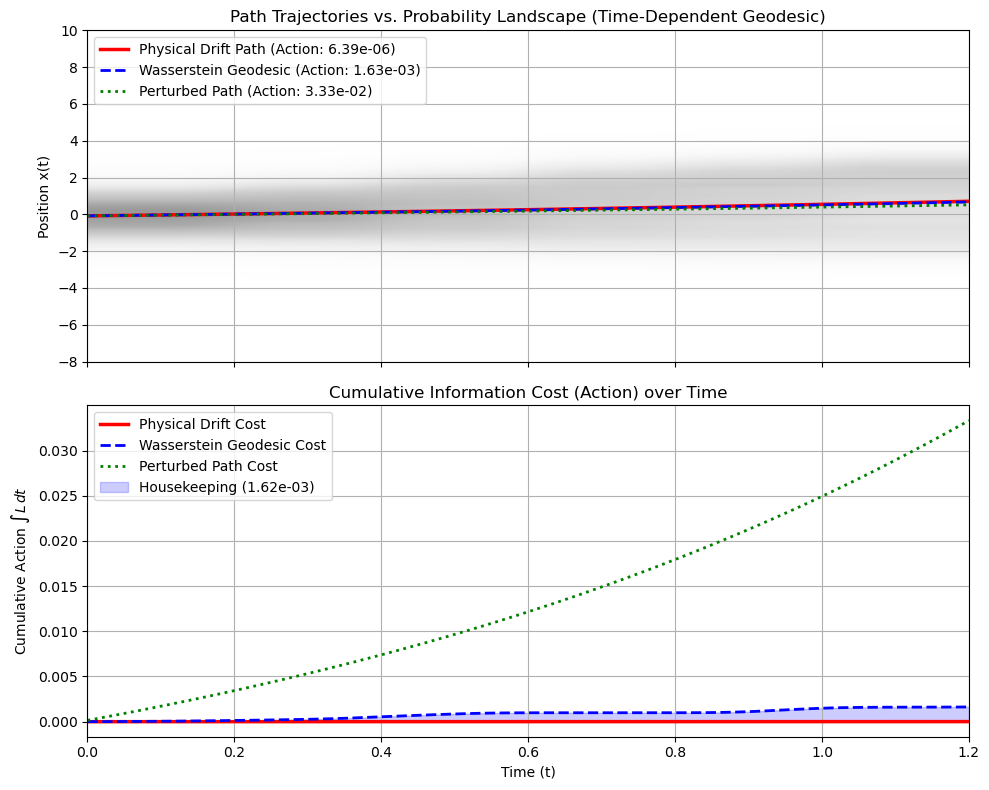

In [16]:
def calculate_onsager_machlup_action_time_dependent(u_field, D_field, p_initial, grid_x, end_time, 
                                                    h_x_factor, h_v_global, dt=0.01):
    """
    Calculates Onsager-Machlup Action with TIME-DEPENDENT Wasserstein Geodesic.
    Uses pre-computed v_ex(x,t) from GLOBAL_DATA['v_ex_by_t'].
    """
    print("\n--- Running Onsager-Machlup & Time-Dependent Wasserstein Geodesic Analysis ---")
    
    # Check if v_ex is available
    if 'v_ex_by_t' not in GLOBAL_DATA:
        print("ERROR: Need to pre-compute v_ex first!")
        return
    
    # Interpolators for static fields
    u_interp = lambda x: np.interp(x, grid_x, u_field)
    D_interp = lambda x: np.interp(x, grid_x, D_field)
    
    # Create 2D interpolator for v_ex(x, t)
    from scipy.interpolate import RectBivariateSpline
    all_times = np.array(GLOBAL_DATA['all_times'])
    v_ex_matrix = np.array([GLOBAL_DATA['v_ex_by_t'][t] for t in all_times]).T  # Shape: (n_x, n_t)
    
    v_ex_interp_2d = RectBivariateSpline(grid_x, all_times, v_ex_matrix, kx=1, ky=1)
    
    def v_ex_interp(x, t):
        """Get v_ex at position x and time t."""
        return v_ex_interp_2d(x, t)[0, 0]
    
    # Path generation
    n_steps = int(end_time / dt)
    t_path = np.linspace(0, end_time, n_steps)
    start_x = grid_x[np.argmax(p_initial)]
    
    # Path 1: Drift path
    print("  Generating drift path...")
    x_drift = np.zeros_like(t_path)
    x_drift[0] = start_x
    for i in range(n_steps - 1):
        x_drift[i+1] = x_drift[i] + u_interp(x_drift[i]) * dt
    
    # Path 2: Time-dependent Wasserstein geodesic
    print("  Generating time-dependent Wasserstein geodesic...")
    x_geodesic = np.zeros_like(t_path)
    x_geodesic[0] = start_x
    for i in range(n_steps - 1):
        v_ex_here = v_ex_interp(x_geodesic[i], t_path[i])
        x_geodesic[i+1] = x_geodesic[i] + v_ex_here * dt
    
    # Path 3: Wrong path
    print("  Generating perturbed path...")
    x_wrong = np.zeros_like(t_path)
    x_wrong[0] = start_x
    for i in range(n_steps - 1):
        x_wrong[i+1] = x_wrong[i] + 0.8 * u_interp(x_wrong[i]) * dt
    
    # Calculate Actions
    def analyze_path(x_path):
        v_path = np.gradient(x_path, dt)
        u_on_path = u_interp(x_path)
        D_on_path = D_interp(x_path)
        L_path = (v_path - u_on_path)**2 / (4 * D_on_path + 1e-30)
        S_cum = np.cumsum(L_path) * dt
        return S_cum, S_cum[-1]

    S_cum_drift, S_tot_drift = analyze_path(x_drift)
    S_cum_geo, S_tot_geo = analyze_path(x_geodesic)
    S_cum_wrong, S_tot_wrong = analyze_path(x_wrong)

    print(f"  Action (Cost) of Physical Drift Path:        {S_tot_drift:.2e}")
    print(f"  Action (Cost) of Time-Dep Wasserstein Path:  {S_tot_geo:.2e}")
    print(f"  Action (Cost) of Perturbed Path:             {S_tot_wrong:.2e}")
    
    housekeeping = S_tot_geo - S_tot_drift
    print(f"  Housekeeping Dissipation (Geo - Drift):      {housekeeping:.2e}")

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Subplot 1: Trajectories
    ax1.set_title("Path Trajectories vs. Probability Landscape (Time-Dependent Geodesic)")
    ax1.set_ylabel("Position x(t)")
    
    # Background Density
    print("  Generating background density heatmap...")
    p_x_t_snapshots = []
    for t in GLOBAL_DATA['all_times']:
        p_xv_t = kde_2d(GLOBAL_DATA['samples_by_t'][t], grid_x, GLOBAL_DATA['grid_v'], h_x_factor, h_v_global)
        _, _, p_t = calculate_physics_from_2d_kde(p_xv_t, GLOBAL_DATA['grid_v'], GLOBAL_DATA['p_thresh'])
        p_x_t_snapshots.append(p_t)
    p_x_t_matrix = np.stack(p_x_t_snapshots, axis=1)
    
    ax1.imshow(p_x_t_matrix, aspect='auto', origin='lower', 
               extent=[0, end_time, grid_x[0], grid_x[-1]], 
               cmap='Greys', alpha=0.4)

    ax1.plot(t_path, x_drift, 'r-', lw=2.5, label=f"Physical Drift Path (Action: {S_tot_drift:.2e})")
    ax1.plot(t_path, x_geodesic, 'b--', lw=2, label=f"Wasserstein Geodesic (Action: {S_tot_geo:.2e})")
    ax1.plot(t_path, x_wrong, 'g:', lw=2, label=f"Perturbed Path (Action: {S_tot_wrong:.2e})")
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Subplot 2: Cumulative Action
    ax2.set_title("Cumulative Information Cost (Action) over Time")
    ax2.set_ylabel(r"Cumulative Action $\int L\, dt$")
    ax2.set_xlabel("Time (t)")
    
    ax2.plot(t_path, S_cum_drift, 'r-', lw=2.5, label="Physical Drift Cost")
    ax2.plot(t_path, S_cum_geo, 'b--', lw=2, label="Wasserstein Geodesic Cost")
    ax2.plot(t_path, S_cum_wrong, 'g:', lw=2, label="Perturbed Path Cost")
    
    # Shade housekeeping dissipation
    ax2.fill_between(t_path, S_cum_drift, S_cum_geo, alpha=0.2, color='blue', 
                     label=f'Housekeeping ({housekeeping:.2e})')
    
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    plt.tight_layout()
    print("  Time-dependent Onsager-Machlup analysis complete.")

# Replace the old calculate_onsager_machlup_action call with:
print("\n--- Running Time-Dependent Onsager-Machlup Analysis ---")
calculate_onsager_machlup_action_time_dependent(
    u_final, 
    D_final, 
    p_initial_t0, 
    grid_x, 
    end_time=GLOBAL_DATA['all_times'][-1],
    h_x_factor=h_x_factor_best,
    h_v_global=h_v_best
)


--- Running Physics-Driven (Lagrangian) Forecast ---
  Simulating forecast with DISCOVERED laws...
  Simulating forecast with TRUE laws...
  Forecast t=1.40: L2 Error = 5.2534e-02
  Forecast t=1.60: L2 Error = 6.9235e-02
  Physics-driven forecast complete.


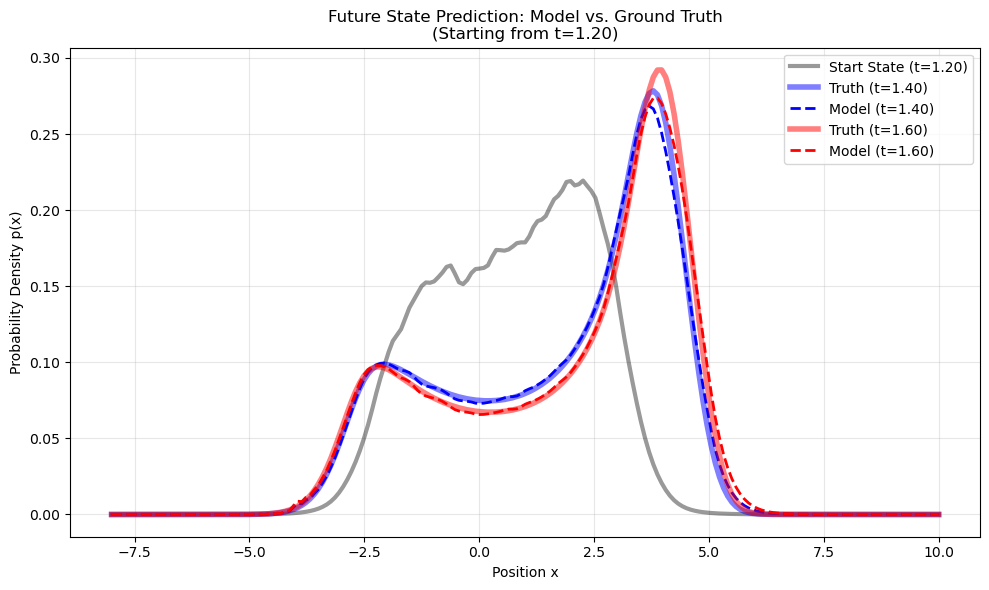

In [23]:
def run_physics_driven_forecast(u_disc, D_disc, u_true, D_true, p_init, grid_x, t_start, duration=0.4):
    """
    Predicts future state by solving the FPE forward using the DISCOVERED physics,
    and compares it to the simulation using TRUE physics.
    """
    print("\n--- Running Physics-Driven (Lagrangian) Forecast ---")
    
    # Define forecast times (e.g., +0.2 and +0.4 time units)
    # You can extend 'duration' to see long-term divergence
    times = [t_start + duration/2, t_start + duration]
    
    # 1. Forecast using DISCOVERED physics (The Model)
    print("  Simulating forecast with DISCOVERED laws...")
    p_forecast_disc = solve_fpe_forward(u_disc, D_disc, p_init, grid_x, times)
    
    # 2. Forecast using TRUE physics (Ground Truth)
    print("  Simulating forecast with TRUE laws...")
    p_forecast_true = solve_fpe_forward(u_true, D_true, p_init, grid_x, times)
    
    # 3. Plot comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title(f"Future State Prediction: Model vs. Ground Truth\n(Starting from t={t_start:.2f})")
    ax.set_xlabel("Position x")
    ax.set_ylabel("Probability Density p(x)")
    ax.grid(True, alpha=0.3)
    
    # Initial state
    ax.plot(grid_x, p_init, 'k-', lw=3, alpha=0.4, label=f"Start State (t={t_start:.2f})")
    
    # Snapshots
    colors = ['b', 'r'] # Colors for time steps
    styles = ['--', ':']
    
    for i, t in enumerate(times):
        # True
        ax.plot(grid_x, p_forecast_true[i], color=colors[i], linestyle='-', alpha=0.5, lw=4, 
                label=f"Truth (t={t:.2f})")
        # Discovered
        ax.plot(grid_x, p_forecast_disc[i], color=colors[i], linestyle='--', lw=2, 
                label=f"Model (t={t:.2f})")
        
        # Calculate error (L2 norm)
        error = np.sqrt(np.sum((p_forecast_true[i] - p_forecast_disc[i])**2))
        print(f"  Forecast t={t:.2f}: L2 Error = {error:.4e}")

    ax.legend()
    plt.tight_layout()
    print("  Physics-driven forecast complete.")

    return p_forecast_true, p_forecast_disc

run_physics_driven_forecast(
        u_final,            # Discovered drift
        D_final,            # Discovered diffusion
        u_true_on_grid,     # True drift
        D_true_on_grid,     # True diffusion
        p_x_final,          # Starting density (t=1.2)
        grid_x,
        t_start=final_time,
        duration=0.4        # Predict t=1.4 and t=1.6
    )

    # --- P. Show all plots ---
plt.show()

FORECAST COMPARISON: FPE Solver vs Flux-Based Method

Time t = 0.2:
  L2 Error vs Ground Truth:
    FPE Solver:  3.407776e-03 (0.679%)
    Flux-Based:  3.666948e-03 (0.730%)
    Winner: FPE Solver
  Max Absolute Error:
    FPE Solver:  4.196095e-03
    Flux-Based:  4.408758e-03
  Method Difference (L2): 5.249571e-04

Time t = 0.4:
  L2 Error vs Ground Truth:
    FPE Solver:  4.640593e-03 (0.974%)
    Flux-Based:  5.111181e-03 (1.073%)
    Winner: FPE Solver
  Max Absolute Error:
    FPE Solver:  5.434890e-03
    Flux-Based:  5.764436e-03
  Method Difference (L2): 9.127089e-04



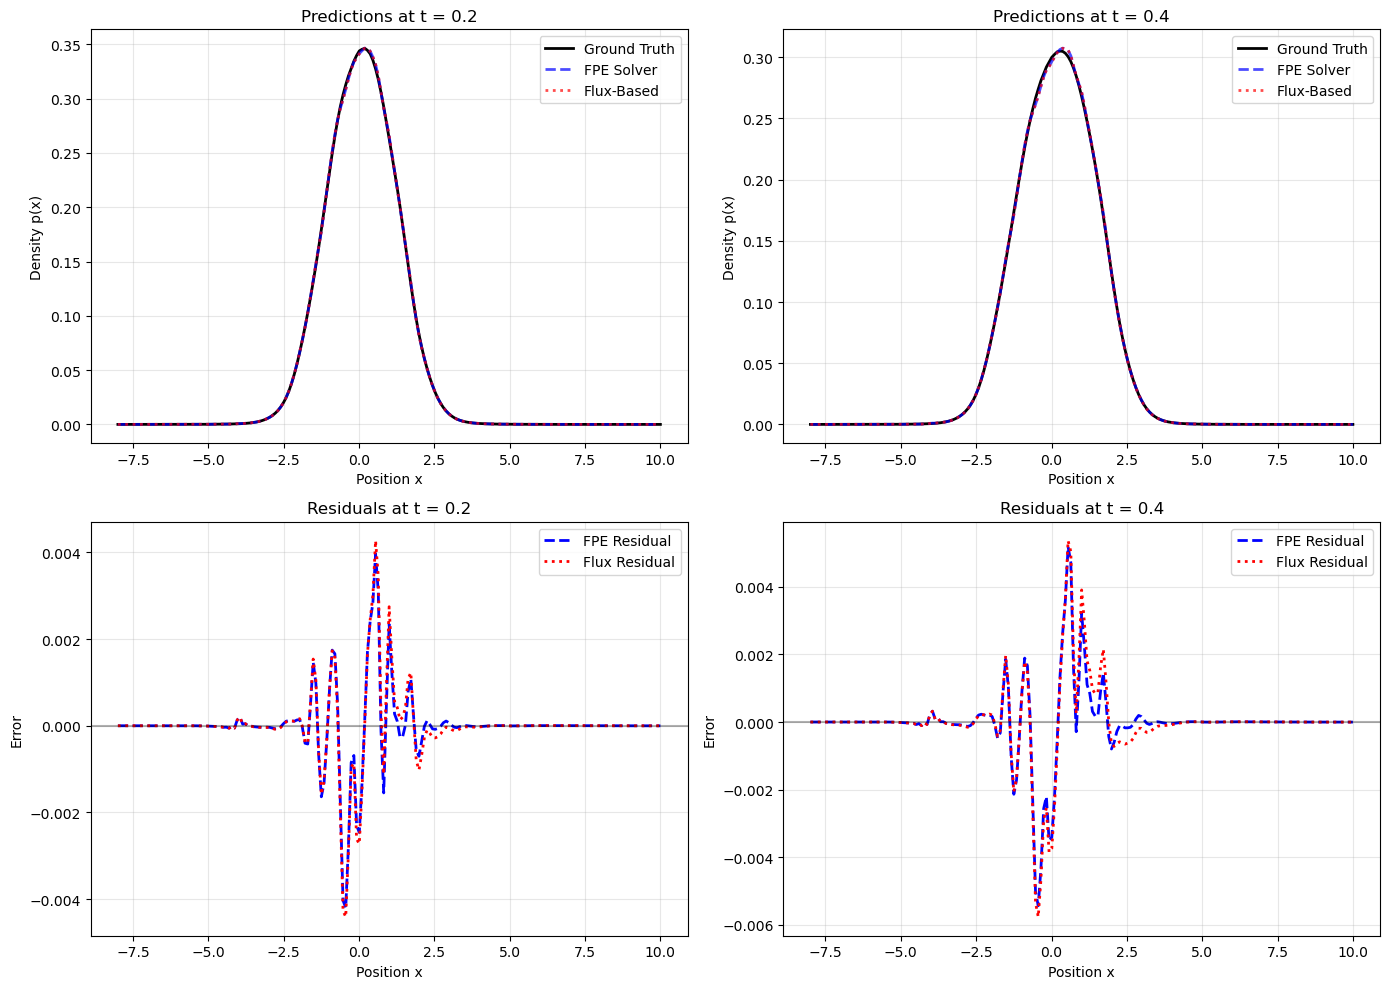

In [30]:
def flux_based_forecast(u_field, D_field, p_initial, grid_x, target_times, dt=0.01):
    """
    Predicts future density evolution using direct flux computation.
    
    Args:
        u_field: Discovered drift field u(x)
        D_field: Discovered diffusion field D(x)
        p_initial: Initial probability density p(x, t=0)
        grid_x: Spatial grid
        target_times: Times at which to return predictions
        dt: Integration timestep
        
    Returns:
        List of density snapshots at target_times
    """
    dx = grid_x[1] - grid_x[0]
    p_current = p_initial.copy()
    results = []
    current_time = 0.0
    
    for t_target in target_times:
        # Simulate from current_time to t_target
        n_steps = int(np.ceil((t_target - current_time) / dt))
        
        for _ in range(n_steps):
            # Compute flux components
            J_adv = u_field * p_current
            grad_p = np.gradient(p_current, dx)
            J_diff = -D_field * grad_p
            J_total = J_adv + J_diff
            
            # Compute flux divergence
            div_J = np.gradient(J_total, dx)
            
            # Update density
            p_current = p_current - dt * div_J
            
            # Enforce physical constraints
            p_current = np.maximum(p_current, 0)
            p_current /= np.trapz(p_current, grid_x)
        
        results.append(p_current.copy())
        current_time = t_target
    
    return results

# Compare with FPE solver
times = [0.2, 0.4]
p_forecast_true = solve_fpe_forward(u_true_on_grid, D_true_on_grid, p_initial_t0, grid_x, times)
# Method 1: FPE forward solver (existing)
p_forecast_fpe = solve_fpe_forward(u_final, D_final, p_initial_t0, grid_x, times)
# Method 2: Flux-based (new)
p_forecast_flux = flux_based_forecast(u_final, D_final, p_initial_t0, grid_x, times)

# Compute residuals
print("="*60)
print("FORECAST COMPARISON: FPE Solver vs Flux-Based Method")
print("="*60)

for i, t in enumerate(times):
    # L2 errors relative to ground truth
    error_fpe = np.sqrt(np.trapz((p_forecast_fpe[i] - p_forecast_true[i])**2, grid_x))
    error_flux = np.sqrt(np.trapz((p_forecast_flux[i] - p_forecast_true[i])**2, grid_x))
    
    # Relative L2 errors
    norm_true = np.sqrt(np.trapz(p_forecast_true[i]**2, grid_x))
    rel_error_fpe = error_fpe / norm_true * 100
    rel_error_flux = error_flux / norm_true * 100
    
    # Max absolute errors
    max_error_fpe = np.max(np.abs(p_forecast_fpe[i] - p_forecast_true[i]))
    max_error_flux = np.max(np.abs(p_forecast_flux[i] - p_forecast_true[i]))
    
    # Direct comparison between methods
    method_diff = np.sqrt(np.trapz((p_forecast_fpe[i] - p_forecast_flux[i])**2, grid_x))
    
    print(f"\nTime t = {t}:")
    print(f"  L2 Error vs Ground Truth:")
    print(f"    FPE Solver:  {error_fpe:.6e} ({rel_error_fpe:.3f}%)")
    print(f"    Flux-Based:  {error_flux:.6e} ({rel_error_flux:.3f}%)")
    print(f"    Winner: {'Flux-Based' if error_flux < error_fpe else 'FPE Solver'}")
    print(f"  Max Absolute Error:")
    print(f"    FPE Solver:  {max_error_fpe:.6e}")
    print(f"    Flux-Based:  {max_error_flux:.6e}")
    print(f"  Method Difference (L2): {method_diff:.6e}")

print("\n" + "="*60)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, t in enumerate(times):
    # Top row: predictions
    axes[0, i].plot(grid_x, p_forecast_true[i], 'k-', label='Ground Truth', lw=2)
    axes[0, i].plot(grid_x, p_forecast_fpe[i], 'b--', label='FPE Solver', lw=2, alpha=0.7)
    axes[0, i].plot(grid_x, p_forecast_flux[i], 'r:', label='Flux-Based', lw=2, alpha=0.7)
    axes[0, i].set_title(f'Predictions at t = {t}')
    axes[0, i].set_xlabel('Position x')
    axes[0, i].set_ylabel('Density p(x)')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)
    
    # Bottom row: residuals
    residual_fpe = p_forecast_fpe[i] - p_forecast_true[i]
    residual_flux = p_forecast_flux[i] - p_forecast_true[i]
    
    axes[1, i].plot(grid_x, residual_fpe, 'b--', label='FPE Residual', lw=2)
    axes[1, i].plot(grid_x, residual_flux, 'r:', label='Flux Residual', lw=2)
    axes[1, i].axhline(0, color='k', linestyle='-', alpha=0.3)
    axes[1, i].set_title(f'Residuals at t = {t}')
    axes[1, i].set_xlabel('Position x')
    axes[1, i].set_ylabel('Error')
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()